In [1]:
# import Backtest class from backtesting.py
import src
from src.backtest import Backtest
# Change in mymodule
from importlib import reload
reload(src.backtest)

import pandas as pd
import numpy as np
from datetime import datetime
import os
# import any from Typing
from typing import Any, List, Union, Tuple, Dict, Optional, Callable
from copy import deepcopy

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import src.cathay_db as db

# Set Model

In [25]:
model_folder_name = '20230719_083148'
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all_select.feather')
listed_ticker = df_factor_all['ticker'].unique().tolist()
df_price_d = pd.read_feather('data/cmoney_price.feather')
df_price_adj_d = pd.read_feather('data/df_adjusted_price.feather')
df_market_cap_melt = pd.read_feather('data/df_market_cap_melt.feather')

df_price_d = df_price_d[df_price_d['股票代號'].isin(listed_ticker)]
df_price_adj_d = df_price_adj_d[df_price_adj_d['股票代號'].isin(listed_ticker)]

df_price_d = df_price_d.drop_duplicates(subset=['股票代號', '日期'], keep='last')
df_price_adj_d = df_price_d.drop_duplicates(subset=['股票代號', '日期'], keep='last')
# df_backtest
# create a open price pivot table from df_backtest, index is ['日期'], columns is ['股票代號'], values is ['開盤價']
df_backtest_open = df_price_d.pivot(index='日期', columns='股票代號', values='開盤價')
df_backtest_open.reset_index().to_feather('data/df_backtest_open.feather')

df_backtest_high = df_price_d.pivot(index='日期', columns='股票代號', values='最高價')
df_backtest_high.reset_index().to_feather('data/df_backtest_high.feather')

df_backtest_low = df_price_d.pivot(index='日期', columns='股票代號', values='最低價')
df_backtest_low.reset_index().to_feather('data/df_backtest_low.feather')

df_backtest_close = df_price_d.pivot(index='日期', columns='股票代號', values='收盤價')
df_backtest_close.reset_index().to_feather('data/df_backtest_close.feather')

df_backtest_volume = df_price_d.pivot(index='日期', columns='股票代號', values='成交量')
df_backtest_volume.reset_index().to_feather('data/df_backtest_volume.feather')

df_backtest_market_cap = df_price_d.pivot(index='日期', columns='股票代號', values='總市值(億)')
df_backtest_market_cap.reset_index().to_feather('data/df_backtest_market_cap.feather')

df_backtest_adj_close = df_price_adj_d.pivot(index='日期', columns='股票代號', values='收盤價')
df_backtest_adj_close.reset_index().to_feather('data/df_backtest_adj_close.feather')

In [2]:
df_backtest_open = pd.read_feather('data/df_backtest_open.feather')
df_backtest_high = pd.read_feather('data/df_backtest_high.feather')
df_backtest_low = pd.read_feather('data/df_backtest_low.feather')
df_backtest_close = pd.read_feather('data/df_backtest_close.feather')
df_backtest_volume = pd.read_feather('data/df_backtest_volume.feather')
df_backtest_market_cap = pd.read_feather('data/df_backtest_market_cap.feather')
df_backtest_adj_close = pd.read_feather('data/df_backtest_adj_close.feather')

# convert the '日期' column to timestamp
df_backtest_open['日期'] = pd.to_datetime(df_backtest_open['日期'])
df_backtest_high['日期'] = pd.to_datetime(df_backtest_high['日期'])
df_backtest_low['日期'] = pd.to_datetime(df_backtest_low['日期'])
df_backtest_close['日期'] = pd.to_datetime(df_backtest_close['日期'])
df_backtest_volume['日期'] = pd.to_datetime(df_backtest_volume['日期'])
df_backtest_market_cap['日期'] = pd.to_datetime(df_backtest_market_cap['日期'])
df_backtest_adj_close['日期'] = pd.to_datetime(df_backtest_adj_close['日期'])

# set the '日期' column as index
df_backtest_open = df_backtest_open.set_index('日期')
df_backtest_high = df_backtest_high.set_index('日期')
df_backtest_low = df_backtest_low.set_index('日期')
df_backtest_close = df_backtest_close.set_index('日期')
df_backtest_volume = df_backtest_volume.set_index('日期')
df_backtest_market_cap = df_backtest_market_cap.set_index('日期')
df_backtest_adj_close = df_backtest_adj_close.set_index('日期')

# set data to float
df_backtest_open = df_backtest_open.astype(float)
df_backtest_high = df_backtest_high.astype(float)
df_backtest_low = df_backtest_low.astype(float)
df_backtest_close = df_backtest_close.astype(float)
df_backtest_volume = df_backtest_volume.astype(float)
df_backtest_market_cap = df_backtest_market_cap.astype(float)
df_backtest_adj_close = df_backtest_adj_close.astype(float)

In [3]:
# create a new dataframe to store the dividend data use the same index as df_backtest_close and columns as df_backtest_close
df_dividend = pd.DataFrame(index=df_backtest_close.index, columns=df_backtest_close.columns)

In [4]:
sql_query = """SELECT * FROM [FinanceOther].[dbo].[modified_cash_dividend]"""

SERVER = "10.198.213.13"
DATABASE = "FinanceOther"
SERVER_UID = "ap00100673"
SERVER_PWD = "00100678_matt"

df_data = db.pd_read_mssql_data(sql_query, SERVER, DATABASE, SERVER_UID, SERVER_PWD)
# set 日期 in df_data to datetime
df_data['日期'] = pd.to_datetime(df_data['日期'])
df_data['現金股利'] = df_data['現金股利'].astype(float)
df_data['股票代號'] = df_data['股票代號'].str.strip()

for i in range(len(df_data)):
    try:
        df_dividend[df_data.loc[i]['股票代號']].loc[df_data.loc[i]['日期']] = df_data.loc[i]['現金股利']
    except:
        pass

In [5]:
df_dividend.fillna(0, inplace=True)

In [6]:
import src
from src.backtest import Backtest
# Change in mymodule
from importlib import reload
reload(src.backtest)

backtest = Backtest()
backtest.version

'0.0.19'

In [7]:
model_folder_name = '20230719_083148'
df_backtest_portfolio = pd.read_feather(f'./data/model/{model_folder_name}/df_select_filter_dividends_yield_top_50.feather')
df_backtest_portfolio['weight'] = 1
apply_restrict_index, base_portfolio_number, restrict_portfolio_number = 1, 50, 60
df_backtest_portfolio_turnover_restricted = pd.read_feather(f'./data/model/{model_folder_name}/df_restrict_result_{apply_restrict_index}_{base_portfolio_number}_{restrict_portfolio_number}.feather')
df_backtest_portfolio_turnover_restricted['weight'] = 1
df_backtest_benchmark = pd.read_feather(f'./data/model/{model_folder_name}/df_select_filter_dividends_yield_benchmark.feather')
df_backtest_benchmark['weight'] = 1

In [8]:
df_position = df_backtest_portfolio.pivot(index = 'date', columns = 'ticker', values = 'weight').fillna(0)

backtest_portfolio = Backtest()
backtest_portfolio.data_market_capital = df_backtest_market_cap
backtest_portfolio.data_open = df_backtest_open
backtest_portfolio.data_close = df_backtest_close
backtest_portfolio.data_adj_close = df_backtest_adj_close
backtest_portfolio.data_high = df_backtest_high
backtest_portfolio.data_low = df_backtest_low
backtest_portfolio.data_volume = df_backtest_volume
backtest_portfolio.data_cash_dividends = df_dividend


backtest_portfolio.init_position()
backtest_portfolio.position = df_position
backtest_portfolio.weighting = 'cw'

backtest_portfolio.run()
# backtest_portfolio.record_to_excel()
# # backtest_portfolio.data_to_excel()

backtest_portfolio_top_50 = backtest_portfolio._record_position_value.sum(axis=1)

In [9]:
df_position = df_backtest_portfolio_turnover_restricted.pivot(index = 'date', columns = 'ticker', values = 'weight').fillna(0)

backtest_portfolio_turnover_restricted = Backtest()
backtest_portfolio_turnover_restricted.data_market_capital = df_backtest_market_cap
backtest_portfolio_turnover_restricted.data_open = df_backtest_open
backtest_portfolio_turnover_restricted.data_close = df_backtest_close
backtest_portfolio_turnover_restricted.data_adj_close = df_backtest_adj_close
backtest_portfolio_turnover_restricted.data_high = df_backtest_high
backtest_portfolio_turnover_restricted.data_low = df_backtest_low
backtest_portfolio_turnover_restricted.data_volume = df_backtest_volume
backtest_portfolio_turnover_restricted.data_cash_dividends = df_dividend


backtest_portfolio_turnover_restricted.init_position()
backtest_portfolio_turnover_restricted.position = df_position
backtest_portfolio_turnover_restricted.weighting = 'cw'

backtest_portfolio_turnover_restricted.run()
# backtest_portfolio_turnover_restricted.record_to_excel()
# # backtest_portfolio_turnover_restricted.data_to_excel()

backtest_portfolio_turnover_restricted_top_50 = backtest_portfolio_turnover_restricted._record_position_value.sum(axis=1)

In [10]:
df_position = df_backtest_benchmark.pivot(index = 'date', columns = 'ticker', values = 'weight').fillna(0)

backtest_benchmark = Backtest()
backtest_benchmark.data_market_capital = df_backtest_market_cap
backtest_benchmark.data_open = df_backtest_open
backtest_benchmark.data_close = df_backtest_close
backtest_benchmark.data_adj_close = df_backtest_adj_close
backtest_benchmark.data_high = df_backtest_high
backtest_benchmark.data_low = df_backtest_low
backtest_benchmark.data_volume = df_backtest_volume
backtest_benchmark.data_cash_dividends = df_dividend


backtest_benchmark.init_position()
backtest_benchmark.position = df_position
backtest_benchmark.weighting = 'cw'

backtest_benchmark.run()
# backtest_benchmark.record_to_excel()
# # backtest_benchmark.data_to_excel()

backtest_benchmark_top_50 = backtest_benchmark._record_position_value.sum(axis=1)

In [11]:
df_portfolio_yearly_summary = backtest_portfolio.summary_statistics('yearly')
df_portfolio_turnover_restricted_yearly_summary = backtest_portfolio_turnover_restricted.summary_statistics('yearly')
df_portfolio_turnover_restricted_yearly_summary.columns = ['yearly_period'] + [x + '_turnover_restrict' for x in df_portfolio_turnover_restricted_yearly_summary.columns[1:]]
df_benchmark_yearly_summary = backtest_benchmark.summary_statistics('yearly')

In [12]:
df_yearly_summary = pd.merge(df_portfolio_yearly_summary, df_benchmark_yearly_summary, on='yearly_period', suffixes=('_portfolio', '_benchmark'))
df_yearly_summary = pd.merge(df_yearly_summary, df_portfolio_turnover_restricted_yearly_summary, on='yearly_period')

In [13]:
df_yearly_summary['win_port_bench'] = np.where(df_yearly_summary['yearly_return_portfolio'] > df_yearly_summary['yearly_return_benchmark'], 1, 0)
df_yearly_summary['win_turn_res_bench'] = np.where(df_yearly_summary['yearly_return_turnover_restrict'] > df_yearly_summary['yearly_return_benchmark'], 1, 0)

In [14]:
df_yearly_summary[['yearly_period','yearly_return_portfolio','yearly_return_turnover_restrict','yearly_return_benchmark','win_port_bench','win_turn_res_bench']]

,yearly_period,yearly_return_portfolio,yearly_return_turnover_restrict,yearly_return_benchmark,win_port_bench,win_turn_res_bench
0,2005,-0.095043,-0.084613,-0.082255,0,0
1,2006,0.125568,0.123952,0.145058,0,0
2,2007,0.033868,0.098550,0.099709,0,0
3,2008,-0.317594,-0.328525,-0.378758,1,1
4,2009,0.580123,0.198677,0.405431,1,0
5,2010,0.008190,0.054682,0.147316,0,0
6,2011,-0.088441,-0.116548,-0.082823,0,0
7,2012,0.107923,0.100184,-0.005924,1,1
8,2013,0.058550,0.094104,0.017199,1,1
9,2014,0.063704,0.124925,0.080429,0,1


<Axes: >

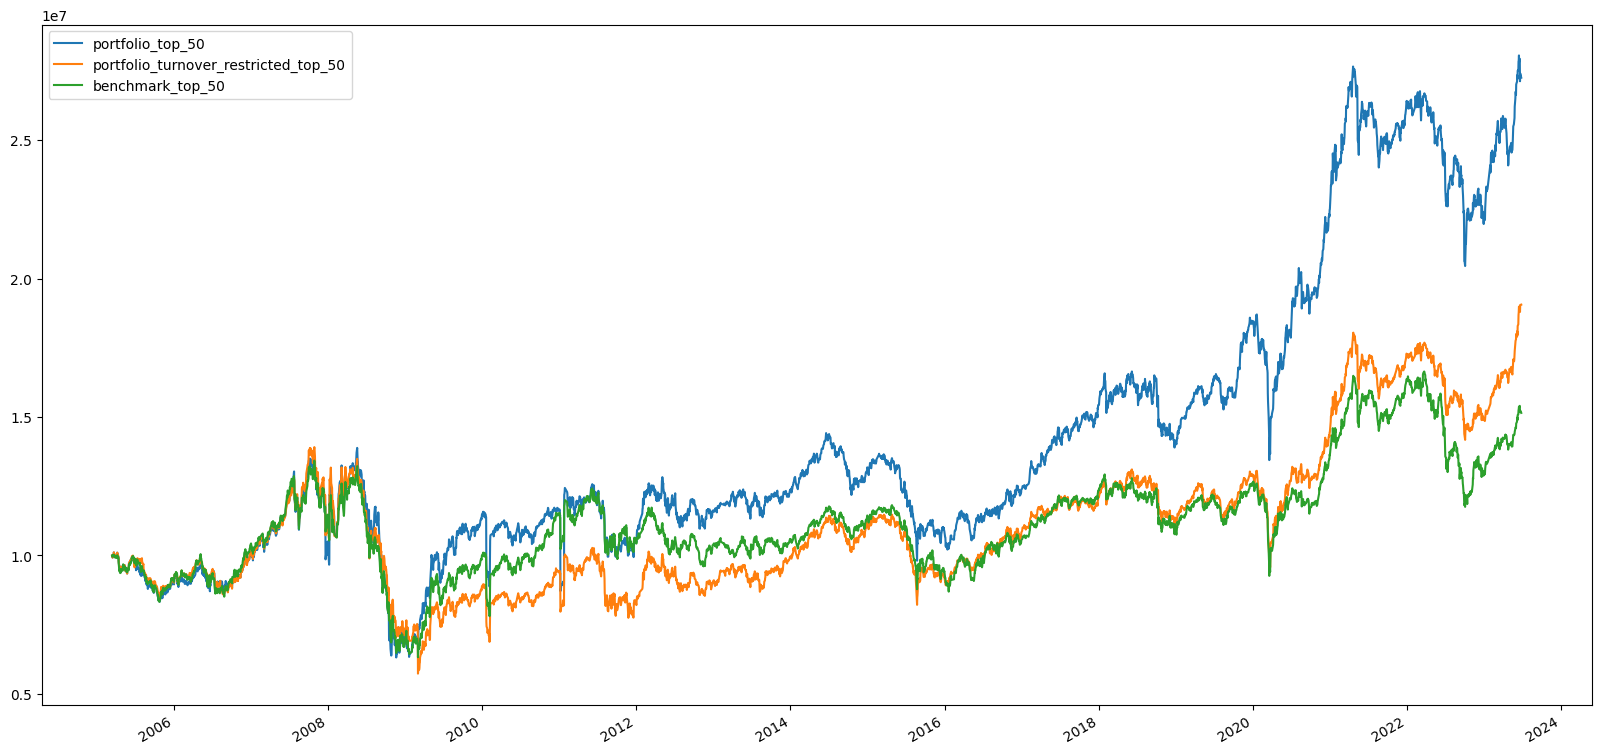

In [15]:
df_index = pd.concat([backtest_portfolio_top_50,backtest_portfolio_turnover_restricted_top_50, backtest_benchmark_top_50],axis=1)
df_index.columns = ['portfolio_top_50','portfolio_turnover_restricted_top_50','benchmark_top_50']
df_index.plot(figsize=(20,10))